In [1]:
#import csv
#import glob
import os
#import matplotlib.pyplot as plt

import librosa
import numpy as np
from keras import Sequential
from keras import Model
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as skm

from keras.models import model_from_json

import struct

In [2]:
def load_file(fname):
    with open(fname, 'rb') as file:
        data = file.read()
        file.close()
    return data

def load_floats(fname):
    data = load_file(fname)
    fmt = "%df" % (len(data)/4)
    frombin = np.asarray(struct.unpack(fmt, data))
    return frombin

def load_double(fname):
    data = load_file(fname)
    fmt = "%dd" % (len(data)/8)
    frombin = np.asarray(struct.unpack(fmt, data))
    return frombin

def stats(nparr):
    print("Size: ", nparr.shape)
    print("Mean: ", nparr.mean())
    print("Median: ", np.median(nparr))
    print("StdDev: ", nparr.std(ddof=1))
    print("Min: ", nparr.min())
    print("Max: ", nparr.max())

In [3]:
loaded_model_json = load_file("model_binary.json")
model = model_from_json(loaded_model_json)
model.load_weights(os.path.join("","model_binary.h5"))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 38, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 8, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 6, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 4224)              0

In [5]:
np.array(model.layers[0].weights[0]).tofile("BinaryV1conv2d_kernel_array.bin_weight")
np.array(model.layers[0].weights[1]).tofile("BinaryV1conv2d_bias_array.bin_weight")

np.array(model.layers[2].weights[0]).tofile("BinaryV1conv2d_1_kernel_array.bin_weight")
np.array(model.layers[2].weights[1]).tofile("BinaryV1conv2d_1_bias_array.bin_weight")

np.array(model.layers[4].weights[0]).tofile("BinaryV1conv2d_2_kernel_array.bin_weight")
np.array(model.layers[4].weights[1]).tofile("BinaryV1conv2d_2_bias_array.bin_weight")

np.array(model.layers[6].weights[0]).tofile("BinaryV1dense_kernel_array.bin_weight")
np.array(model.layers[6].weights[1]).tofile("BinaryV1dense_bias_array.bin_weight")

np.array(model.layers[7].weights[0]).tofile("BinaryV1dense_1_kernel_array.bin_weight")
np.array(model.layers[7].weights[1]).tofile("BinaryV1dense_1_bias_array.bin_weight")

In [6]:
import glob
file_url = 'T:\\mosquitos\\train_correctorder'
sub_dirs = ["0","1"]
file_ext="*.wav"
hop_length = 256
frames = 40
sample_rate = 8000

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

print("Extract features from {} list: {}", file_url, sub_dirs)
window_size = hop_length * (frames - 1)
signals_pos = []
signals_neg = []

for l, sub_dir in enumerate(sub_dirs):
    for fn in glob.glob(os.path.join(file_url, sub_dir, file_ext)):
        sound_clip, _ = librosa.load(fn, sr=sample_rate)
        #print('Extracting features from: ' + fn)
        label = fn.split('\\')[-2]
        for (start, end) in windows(sound_clip, window_size):
            if (len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                lb = int(label)
                if lb == 0:
                    signals_neg.append(signal)
                else:
                    signals_pos.append(signal)
                    
print("finish reading")

Extract features from {} list: {} T:\mosquitos\train_correctorder ['0', '1']
finish reading


In [7]:
len(signals_neg)

21972

In [8]:
len(signals_pos)

2756

In [9]:
import random
random.seed(a="PROJETO DE DIPLOMACAUM CASTEL", version=2)
rnd_pos = random.sample(signals_pos, 120)
rnd_neg = random.sample(signals_neg, 120)

In [10]:
np.all(np.asarray(rnd_pos)[1,:] == rnd_pos[1])

True

In [11]:
np.asarray(rnd_pos).tofile("p120_9984.fbin")
np.asarray(rnd_neg).tofile("n120_9984.fbin")

In [12]:
pos_arr120 = np.asarray(rnd_pos)
neg_arr120 = np.asarray(rnd_neg)

feat = []
for i in range(0,120):
    melspec = librosa.feature.melspectrogram(y=pos_arr120[i], n_mels=60, sr=8000, n_fft=1024, hop_length=256)
    dbcalc = librosa.power_to_db(melspec, ref=np.max)
    normcalc = dbcalc / 80 + 1
    flatten = normcalc.flatten()[:, np.newaxis].T
    toNN = np.asarray([flatten]).reshape(60,40,1)
    feat.append(toNN)
    
    melspec = librosa.feature.melspectrogram(y=neg_arr120[i], n_mels=60, sr=8000, n_fft=1024, hop_length=256)
    dbcalc = librosa.power_to_db(melspec, ref=np.max)
    normcalc = dbcalc / 80 + 1
    flatten = normcalc.flatten()[:, np.newaxis].T
    toNN = np.asarray([flatten]).reshape(60,40,1)
    feat.append(toNN)



In [13]:
res = model.predict(np.asarray(feat))

8/8 [==============================] - 0s 15ms/step


In [14]:
import datetime
a = datetime.datetime.now()
model.predict(np.asarray([feat[6]]))
b = datetime.datetime.now()
(b-a).total_seconds()

1/1 [==============================] - 0s 29ms/step


0.091

In [15]:

a = datetime.datetime.now()

melspec = librosa.feature.melspectrogram(y=neg_arr120[0], n_mels=60, sr=8000, n_fft=1024, hop_length=256)
dbcalc = librosa.power_to_db(melspec, ref=np.max)
normcalc = dbcalc / 80 + 1
flatten = normcalc.flatten()[:, np.newaxis].T
toNN = np.asarray([flatten]).reshape(60,40,1)

b = datetime.datetime.now()
(b-a).total_seconds()

0.008002

In [16]:
res.shape

(240, 2)

In [17]:
i=5
res[(i-1)*2:(i-1)*2+2,:]

array([[0.11799723, 0.9299436 ],
       [0.9962553 , 0.0125499 ]], dtype=float32)

In [18]:
(res[:,1] > res[:,0])[0::2]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
       False,  True,  True])

In [19]:
#res

In [20]:
esp32outFloat = load_floats("outputs120_pn_2_2---FLOATFPRECISION.fbin").reshape(240,2)
esp32outDouble = load_floats("outputs120_pn_2_2---DOUBLEFPRECISION.fbin").reshape(240,2)

In [21]:
diffF = res-esp32outFloat
stats(diffF)

Size:  (240, 2)
Mean:  -3.958985562744927e-09
Median:  0.0
StdDev:  6.239832816044236e-07
Min:  -3.635883331298828e-06
Max:  3.4868717193603516e-06


In [22]:
diffD = res-esp32outDouble
stats(diffD)

Size:  (240, 2)
Mean:  9.96974607015387e-10
Median:  0.0
StdDev:  1.5005702866602839e-07
Min:  -1.0132789611816406e-06
Max:  1.0132789611816406e-06


In [23]:
stats(abs(diffF))
stats(abs(diffD))

Size:  (240, 2)
Mean:  3.0016991689958635e-07
Median:  5.960464477539063e-08
StdDev:  5.468827650037293e-07
Min:  0.0
Max:  3.635883331298828e-06
Size:  (240, 2)
Mean:  7.289783086822984e-08
Median:  8.207280188798904e-09
StdDev:  1.3112177545621566e-07
Min:  0.0
Max:  1.0132789611816406e-06


In [24]:
np.all((res[:,1] > res[:,0]) == (esp32outFloat[:,1]>esp32outFloat[:,0]))

True

In [25]:
np.all((res[:,1] > res[:,0]) == (esp32outDouble[:,1]>esp32outDouble[:,0]))

True

In [26]:
stats(abs(res[:,1]-res[:,0]))

Size:  (240,)
Mean:  0.7633091
Median:  0.94322133
StdDev:  0.30812207
Min:  0.00013041496
Max:  1.0


Text(0.5, 1.0, '')

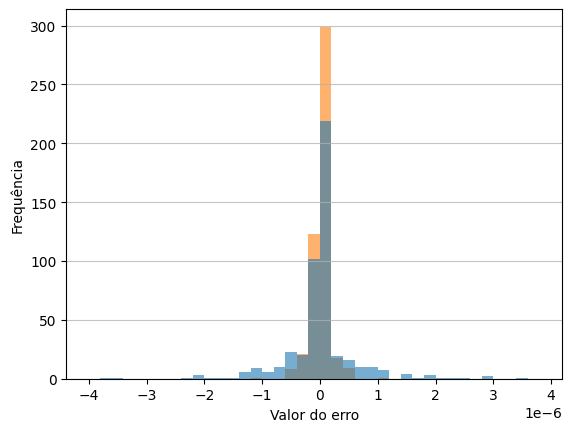

In [27]:
import matplotlib.pyplot as plt

hist, bin_edges = np.histogram(diffF,bins=np.arange(-4e-6,4e-6,2e-7))#range=(-5e-6,+5e-6),

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist([diffF.flatten(),diffD.flatten()], bins=bin_edges, histtype="stepfilled", alpha=0.6)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Valor do erro')
plt.ylabel('Frequência')
plt.title('')

#plt.savefig("../Imagens autorais PD/HistrogramaErroFix2.png", dpi=300)

{'whiskers': [<matplotlib.lines.Line2D at 0x13d59568970>,
 'caps': [<matplotlib.lines.Line2D at 0x13d595770d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x13d595685e0>],
 'medians': [<matplotlib.lines.Line2D at 0x13d595777f0>],
 'fliers': [],
 'means': []}

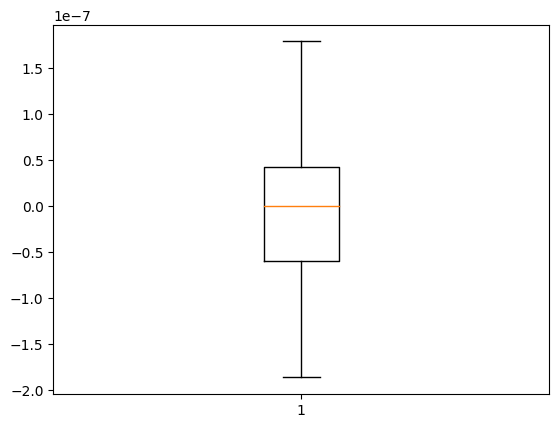

In [28]:
plt.boxplot([diffF.flatten()],sym='', notch=None, bootstrap=1000, vert=None, patch_artist=None, widths=None)

In [29]:
diffD[:,1].mean()

4.950898388434918e-09

In [30]:
stats(diffF.flatten())

Size:  (480,)
Mean:  -3.958985562744927e-09
Median:  0.0
StdDev:  6.239832816044236e-07
Min:  -3.635883331298828e-06
Max:  3.4868717193603516e-06


Text(0.5, 1.0, '')

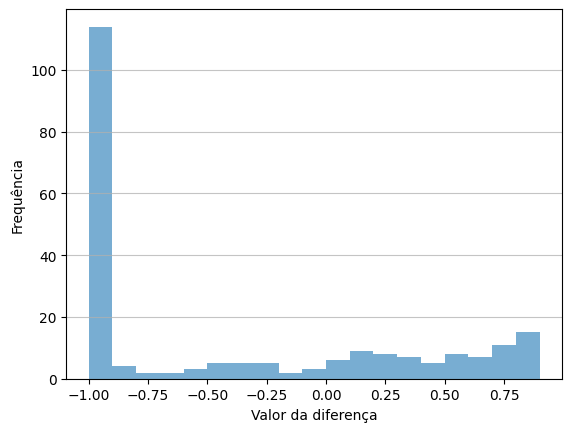

In [31]:
#hist, bin_edges = np.histogram(diffF,bins=np.arange(-4e-6,4e-6,2e-7))#range=(-5e-6,+5e-6),
hist, bin_edges = np.histogram(res[:,1]-res[:,0], np.arange(-1,1,0.1))

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(([res[:,1]-res[:,0]]), bins=bin_edges, histtype="stepfilled", alpha=0.6)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Valor da diferença')
plt.ylabel('Frequência')
plt.title('')

In [32]:
np.abs(res[:,1]-res[:,0]).min()

0.00013041496

In [33]:
def intermediate_layer(model,i,data):
    if i == 0:
        return data
    else:
        XX = model.input
        YY = model.layers[i-1].output
        new_model = Model(XX, YY)
        return new_model.predict(data)

In [34]:
t = np.array([[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]])
u = t*10
t

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15]])

In [35]:
t2 = t.T.flatten()[:,np.newaxis].T
u2 = u.T.flatten()[:,np.newaxis].T

t2

array([[ 1,  6, 11,  2,  7, 12,  3,  8, 13,  4,  9, 14,  5, 10, 15]])

In [36]:
t3 = np.asarray([t2,u2]).reshape(2,3,5,1)
t3[0,:,:,0]

array([[ 1,  6, 11,  2,  7],
       [12,  3,  8, 13,  4],
       [ 9, 14,  5, 10, 15]])

In [37]:
sdinp = load_floats("n120_9984.fbin")[0:9984]


In [39]:
#MelInp = load_double("MelInp.dbin")


In [ ]:
#sdinp[2450:2500]

In [ ]:
#MelInp[2450:2500]

In [ ]:
#a = 2450
#sdinp[a:a+50]-MelInp[a:a+50]

In [ ]:
#MelInp = load_double("MelInp.dbin")
#stats(MelInp)

In [ ]:
#toDb = load_double("TodBInp.dbin")
#stats(toDb)

In [ ]:
#NormImp = load_double("NormInp.dbin")
#stats(NormImp)

In [40]:
melspec = librosa.feature.melspectrogram(y=MelInp, n_mels=60, sr=8000, n_fft=1024, hop_length=256)
dbcalc = librosa.power_to_db(melspec, ref=np.max)
normcalc = dbcalc / 80 + 1
flatten = normcalc.flatten()[:, np.newaxis].T
toNN = np.asarray([flatten]).reshape(1,60,40,1)

NameError: name 'MelInp' is not defined

In [ ]:
melspec.dtype

In [ ]:
np.asarray([normcalc[:,:,np.newaxis]]).shape

In [ ]:
stats(np.asarray([melspec]).reshape(1,60,40,1)-toDb.reshape(1,60,40,1))

In [ ]:
stats(dbcalc.reshape(1,60,40,1)-NormImp.reshape(1,60,40,1))

In [ ]:
stats(melspec)

In [ ]:
stats(toDb)

In [ ]:
stats(in0.reshape(1,60,40,1)-toNN)

In [ ]:
model.predict(toNN.reshape(1,60,40,1))

In [ ]:
model.predict(in0.reshape(1,60,40,1))

In [ ]:
in8

In [ ]:
in0 = load_floats("00.fbin").reshape(60,40)
stats(in0)

In [ ]:
in1 = load_floats("01.fbin").reshape(58,38,32)
stats(in1)

In [ ]:
real1 = intermediate_layer(model,1,in0.reshape(1,60,40,1))
stats(real1)

In [ ]:
in2 = load_floats("02.fbin").reshape(29,19,32)
stats(in2)

In [ ]:
real2 = intermediate_layer(model,2,in0.reshape(1,60,40,1))
stats(real2)

In [ ]:
in3 = load_floats("03.fbin").reshape(27,17,64)
stats(in3)

In [ ]:
real3 = intermediate_layer(model,3,in0.reshape(1,60,40,1))
stats(real3)

In [ ]:
in4 = load_floats("04.fbin").reshape(13,8,64)
stats(in4)

In [ ]:
real4 = intermediate_layer(model,4,in0.reshape(1,60,40,1))
stats(real4)

In [ ]:
in5 = load_floats("05.fbin").reshape(11,6,64)
stats(in5)

In [ ]:
real5 = intermediate_layer(model,5,in0.reshape(1,60,40,1))
stats(real5)

In [ ]:
in6 = load_floats("06.fbin").reshape(4224)
stats(in6)

In [ ]:
real6 = intermediate_layer(model,6,in0.reshape(1,60,40,1))
stats(real6)

In [ ]:
in7 = load_floats("07.fbin").reshape(256)
stats(in7)

In [ ]:
real7 = intermediate_layer(model,7,in0.reshape(1,60,40,1))
stats(real7)

In [ ]:
in8 = load_floats("08.fbin").reshape(2)
stats(in8)

In [ ]:
real8 = intermediate_layer(model,8,in0.reshape(1,60,40,1))
stats(real8)

In [ ]:
real8

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
len(tflite_quant_model)

In [ ]:
model.layers[7].activation

In [ ]:
np.mean(res)

In [ ]:
import pandas as pd
pd.dataFrame = {}

In [ ]:
import bioinfokit.analys.stat
anova = bioinfokit.analys.stat()
anova.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
anova.anova_summary

In [2]:
import pandas as pd
dados = pd.read_excel("../dados.xls",sheet_name="NovosTempos")

In [3]:

dados[dados["Compile Opt"] == "O2"][dados["Clock SPI RAM"]==40][dados["Workaround cache"]=="memw"]

C:\Users\lucas\AppData\Local\Temp\ipykernel_17040\1281730340.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dados[dados["Compile Opt"] == "O2"][dados["Clock SPI RAM"]==40][dados["Workaround cache"]=="memw"]
C:\Users\lucas\AppData\Local\Temp\ipykernel_17040\1281730340.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dados[dados["Compile Opt"] == "O2"][dados["Clock SPI RAM"]==40][dados["Workaround cache"]=="memw"]


,Medidas,Clock SPI RAM,Workaround cache,CPU F,BLKS,FFT Prec,Compile Opt,T Total,T Caract,T NN
0,3,40,memw,160,4,float,O2,9873,693,9180
1,3,40,memw,160,12,float,O2,8560,700,7860
2,3,40,memw,160,33,float,O2,8197,700,7497
6,3,40,memw,160,4,double,O2,11470,2290,9180
7,3,40,memw,160,12,double,O2,10130,2270,7860
8,3,40,memw,160,33,double,O2,9750,2270,7480


In [4]:
a= dados.drop(["Medidas", "BLKS", "T Total", "T NN"],axis="columns")
a = a.groupby(['Clock SPI RAM', "Workaround cache", "CPU F", "FFT Prec", "Compile Opt"]).mean().reset_index()

In [5]:
a

,Clock SPI RAM,Workaround cache,CPU F,FFT Prec,Compile Opt,T Caract
0,40,memw,160,double,O2,2276.666667
1,40,memw,160,double,Os,2346.666667
2,40,memw,160,float,O2,697.666667
3,40,memw,160,float,Os,712.000000
4,40,no,240,double,O2,2239.000000
5,40,no,240,double,Os,2260.000000
6,40,no,240,float,O2,680.000000
7,40,no,240,float,Os,710.000000
8,80,no,240,double,O2,1950.000000
9,80,no,240,double,Os,1980.000000


In [6]:
class1 = a[a["Clock SPI RAM"]==40][a["Workaround cache"]=="memw"][a["CPU F"]==160]
class1

C:\Users\lucas\AppData\Local\Temp\ipykernel_17040\3494735206.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class1 = a[a["Clock SPI RAM"]==40][a["Workaround cache"]=="memw"][a["CPU F"]==160]
C:\Users\lucas\AppData\Local\Temp\ipykernel_17040\3494735206.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class1 = a[a["Clock SPI RAM"]==40][a["Workaround cache"]=="memw"][a["CPU F"]==160]


,Clock SPI RAM,Workaround cache,CPU F,FFT Prec,Compile Opt,T Caract
0,40,memw,160,double,O2,2276.666667
1,40,memw,160,double,Os,2346.666667
2,40,memw,160,float,O2,697.666667
3,40,memw,160,float,Os,712.000000


In [7]:
class_lst = []
float_lst = []
double_lst = []
for spiclock in a["Clock SPI RAM"]:
    b = a[a["Clock SPI RAM"] == spiclock].reset_index()
    for workaround in b["Workaround cache"]:
        c = b[b["Workaround cache"]==workaround].reset_index()
        for freq in c["CPU F"]:
            d = c[c["CPU F"]==freq].reset_index()
            for optim in d["Compile Opt"]:
                e = d[d["Compile Opt"]==optim].reset_index()
                print(e)
                _class = str(spiclock)+'-'+str(workaround)+'-'+str(freq)+'-'+str(optim)
                _double = d[d["FFT Prec"]=="double"]["T Caract"].mean()
                _float  = d[d["FFT Prec"]=="float"]["T Caract"].mean()
                class_lst.append(_class)
                float_lst.append(_float)
                double_lst.append(_double)

ValueError: cannot insert level_0, already exists

In [ ]:
class_lst = []
float_lst = []
double_lst = []

dic_float = {}
dic_double = {}
for i, row in a.iterrows():
    _class = str(row["Clock SPI RAM"])+'-'+str(row["Workaround cache"])+'-'+str(row["CPU F"])+'-'+str(row["Compile Opt"])
    if (row["FFT Prec"]=="float"):
        dic_float[_class] = row["T Caract"]
    else:
        dic_double[_class] = row["T Caract"]
    

In [ ]:
dic_float

In [ ]:
np.asarray(list(dic_float.keys()))
f_values = np.asarray(list(dic_float.values()))
f_values

In [8]:
dic_double

NameError: name 'dic_double' is not defined

In [9]:
fig, ax = plt.subplots()
ax.bar(list(dic_float.keys()),list(dic_float.values()))
fig.xticks(rotation = 90)
ax.set_ylabel('Tempo (ms)')


NameError: name 'plt' is not defined

AttributeError: 'Axes' object has no attribute 'set_xtickslabels'

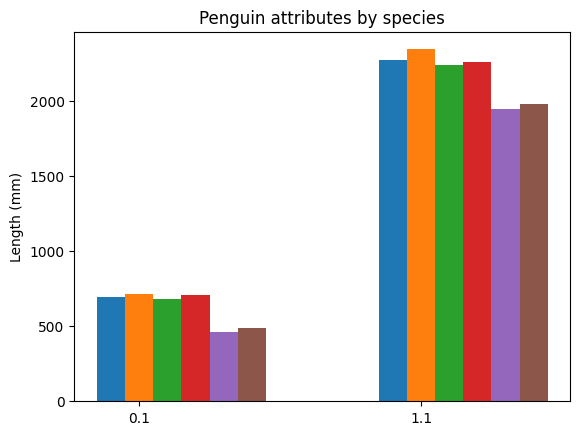

In [10]:
import matplotlib.pyplot as plt
import numpy as np

species = ("float", "double")
penguin_means = {'40-memw-160-O2': (697.6666666666666,2276.6666666666665),
 '40-memw-160-Os': (712.0, 2346.6666666666665),
 '40-no-240-O2': (680.0, 2239.0),
 '40-no-240-Os': (710.0, 2260.0),
 '80-no-240-O2': (460.0, 1950.0),
 '80-no-240-Os': (490.0, 1980.0)}

x = np.arange(len(species))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width)
ax.set_xtickslabels(species)
ax.legend(loc='upper left')
ax.set_ylim(0, 3000)

plt.show()

In [11]:
import plotly.express as px

dic_float = {   '40-memw-160-O2': 2276.6666666666665,
                '40-memw-160-Os': 2346.6666666666665,
                '40-no-240-O2': 2239.0,
                '40-no-240-Os': 2260.0,
                '80-no-240-O2': 1950.0,
                '80-no-240-Os': 1980.0
            }

df = pd.DataFrame.from_dict(dic_float,orient='index')

fig = px.bar(df, y=0,
             labels={'index':'Precisão FFT', '0':'Média de Tempo'},
             barmode='group',
             color=df.index,
             text_auto=True,
             height=400)
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [12]:
y

NameError: name 'y' is not defined

In [13]:
b = dados[dados["Compile Opt"] == "O2"][dados["FFT Prec"]=="double"].drop(["Medidas", "BLKS", "T Total", "T NN"],axis="columns")

C:\Users\lucas\AppData\Local\Temp\ipykernel_17040\4094121389.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = dados[dados["Compile Opt"] == "O2"][dados["FFT Prec"]=="double"].drop(["Medidas", "BLKS", "T Total", "T NN"],axis="columns")


In [14]:
b = dados[dados["Compile Opt"] == "O2"][dados["FFT Prec"]=="double"].drop(["Medidas", "BLKS", "T Total", "T NN"],axis="columns")
b.groupby(['Clock SPI RAM', "Workaround cache", "CPU F", "FFT Prec", "Compile Opt"]).mean()

C:\Users\lucas\AppData\Local\Temp\ipykernel_17040\2095729601.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = dados[dados["Compile Opt"] == "O2"][dados["FFT Prec"]=="double"].drop(["Medidas", "BLKS", "T Total", "T NN"],axis="columns")


T Caract
Clock SPI RAM Workaround cache CPU F FFT Prec Compile Opt             
40            memw             160   double   O2           2276.666667
              no               240   double   O2           2239.000000
80            no               240   double   O2           1950.000000

In [15]:
c = dados[dados["Compile Opt"] == "O2"].drop(["Medidas", "BLKS", "T Total", "T NN"],axis="columns")
c.groupby(['Clock SPI RAM', "Workaround cache", "CPU F", "FFT Prec", "Compile Opt"]).mean()

T Caract
Clock SPI RAM Workaround cache CPU F FFT Prec Compile Opt             
40            memw             160   double   O2           2276.666667
                                     float    O2            697.666667
              no               240   double   O2           2239.000000
                                     float    O2            680.000000
80            no               240   double   O2           1950.000000
                                     float    O2            460.000000

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (9,) and arg 1 with shape (12,).

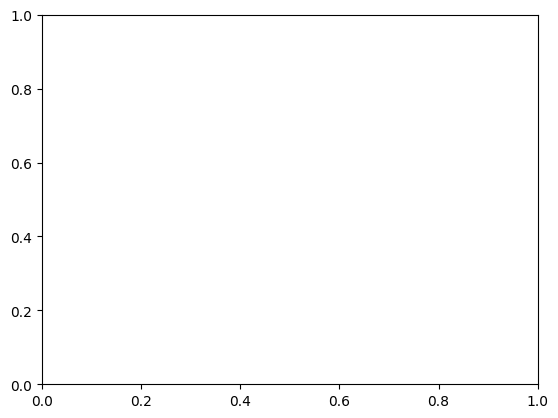

In [16]:
# create plot
fig, ax = plt.subplots()
bar_width = 0.2
opacity = 0.8
x=np.array([1,2,3,4,5,6,7,8,9])
rects1 = plt.bar(x,np.asarray(a["T Caract"]), bar_width,
alpha=opacity,
color='b',
label='Frank')

rects2 = plt.bar(x+bar_width,np.asarray(b["T Caract"]), bar_width,
alpha=opacity,
color='g',
label='Guido')

plt.show()

In [ ]:
np.asarray(a["T Caract"])

In [ ]:
np.asarray(b["T Caract"]).T

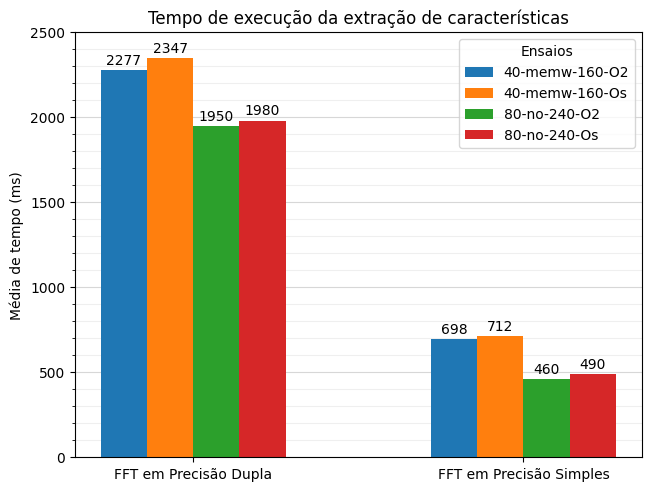

In [52]:
import numpy as np
import matplotlib.pyplot as plt

tipo = ('FFT em Precisão Dupla','FFT em Precisão Simples')

dict_class = {
    '40-memw-160-O2': (2276.6666666666665,697.6666666666666),
    '40-memw-160-Os': (2346.6666666666665,712.0),
    #'40-no-240-O2': (2239.0,680.0),
    #'40-no-240-Os': (2260.0,710.0),
    '80-no-240-O2': (1950.0,460.0),
    '80-no-240-Os': (1980.0,490.0)}

x = np.arange(len(tipo))  # the label locations
width = 0.14  # the width of the bars
multiplier = 0

major_ticks = np.arange(0, 2501, 500)
minor_ticks = np.arange(0, 2501, 100)

fig,ax = plt.subplots(layout='constrained')

for classe,tempo in dict_class.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, tempo, width, label=classe)
    ax.bar_label(rects, padding=2, fmt='%.0f')
    multiplier += 1

ax.set_ylabel('Média de tempo (ms)')
ax.set_title('Tempo de execução da extração de características')
ax.set_xticks(x + width*1.5, tipo)
ax.legend(loc='upper right', title='Ensaios')
ax.set_axisbelow(True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='minor',alpha=0.2,axis='y')
ax.grid(which='major',alpha=0.5,axis='y')
#plt.savefig("../Imagens autorais PD/TempoFFTV2--fix.png", dpi=300)

In [29]:
import pandas as pd
dados = pd.read_excel("../dados.xls",sheet_name="NovosTempos")
a= dados.drop(["Medidas", "T Total", "T Caract", "FFT Prec"],axis="columns")
a = a.groupby(['Clock SPI RAM', "Workaround cache", "CPU F", "Compile Opt","BLKS"]).mean().reset_index()

class_lst = []
float_lst = []
double_lst = []

_dict = {4:{}, 12:{}, 33:{}}
for i, row in a.iterrows():
    _class = str(row["Clock SPI RAM"])+'-'+str(row["Workaround cache"])+'-'+str(row["CPU F"])+'-'+str(row["Compile Opt"])
    if _class in ['40-memw-160-O2', '40-memw-160-Os','80-no-240-O2','80-no-240-Os']:
        if (row["BLKS"] != 11):
            _dict[row["BLKS"]][_class] = row["T NN"]

In [31]:
_dict_plot = {}
for key in _dict[4].keys():
    _dict_plot[key] = (_dict[4][key], _dict[12][key], _dict[33][key])

In [32]:
_dict_plot

{'40-memw-160-O2': (9180.0, 7860.0, 7488.5),
 '40-memw-160-Os': (14125.0, 12915.0, 12515.0),
 '80-no-240-O2': (6200.0, 5135.0, 4755.0),
 '80-no-240-Os': (10070.0, 8990.0, 8660.0)}

40-memw-160-O2 (9180.0, 7860.0, 7488.5)
40-memw-160-Os (14125.0, 12915.0, 12515.0)
80-no-240-O2 (6200.0, 5135.0, 4755.0)
80-no-240-Os (10070.0, 8990.0, 8660.0)


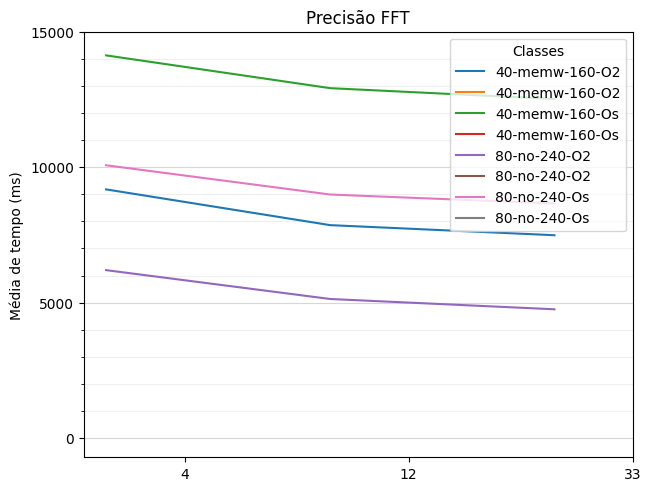

In [33]:
import numpy as np
import matplotlib.pyplot as plt

tipo = (4,12,33)

dict_class = {
    '40-memw-160-O2': (2276.6666666666665,697.6666666666666),
    '40-memw-160-Os': (2346.6666666666665,712.0),
    '40-no-240-O2': (2239.0,680.0),
    '40-no-240-Os': (2260.0,710.0),
    '80-no-240-O2': (1950.0,460.0),
    '80-no-240-Os': (1980.0,490.0)}

dict_class = _dict_plot

x = np.arange(len(tipo))  # the label locations
width = 0.14  # the width of the bars
multiplier = 0

major_ticks = np.arange(0, 15001, 5000)
minor_ticks = np.arange(0, 15001, 1000)

fig,ax = plt.subplots(layout='constrained')

for classe,tempo in dict_class.items():
    print(classe, tempo)
    #offset = width * multiplier
    offset = 0
    rects = ax.plot(x + offset, tempo, width, label=classe)
    #ax.label(rects, padding=2, fmt='%.0f')
    multiplier += 1

#plt.plot(tipo,dict_class[list(dict_class.keys())[0]])
#plt.plot(tipo,dict_class[list(dict_class.keys())[1]])
#plt.plot(tipo,dict_class[list(dict_class.keys())[2]])
#plt.plot(tipo,dict_class[list(dict_class.keys())[3]])

ax.set_ylabel('Média de tempo (ms)')
ax.set_title('Precisão FFT')
ax.set_xticks(x + width*2.5, tipo)
#ax.set_xticks(x, tipo)

ax.legend(loc='upper right', title='Classes')
ax.set_axisbelow(True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='minor',alpha=0.2,axis='y')
ax.grid(which='major',alpha=0.5,axis='y')

In [49]:
YYY_labels = np.asarray(list(_dict_plot.keys()))
YYY = np.asarray(list(_dict_plot.values()))
dic_regress = {}
from scipy.stats import linregress
XXX = 132/np.array((4,12,33))

for i in range(0,4):
    a = XXX
    b = YYY[i,:]
    l = linregress(a, b)
    dic_regress[YYY_labels[i]] = l

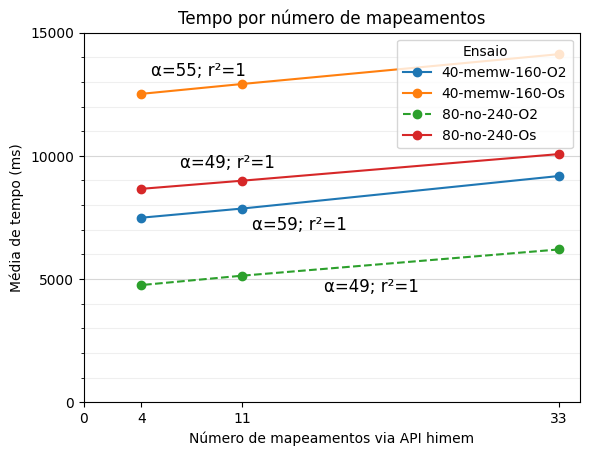

In [51]:
tipo = (132/4,132/12,132/33)
dict_class = _dict_plot

fig,ax = plt.subplots()
ax.plot(tipo,dict_class[list(dict_class.keys())[0]], '-o', label=list(dict_class.keys())[0])
ax.plot(tipo,dict_class[list(dict_class.keys())[1]], '-o', label=list(dict_class.keys())[1])
ax.plot(tipo,dict_class[list(dict_class.keys())[2]], '--o', label=list(dict_class.keys())[2])
ax.plot(tipo,dict_class[list(dict_class.keys())[3]], '-o', label=list(dict_class.keys())[3])
ax.legend(loc='upper right', title='Ensaio')
ax.set_ylabel('Média de tempo (ms)')
ax.set_xlabel('Número de mapeamentos via API himem')
ax.set_title('Tempo por número de mapeamentos')
major_ticks = np.arange(0, 15001, 5000)
minor_ticks = np.arange(0, 15001, 1000)
ax.set_xticks(np.concatenate((np.array([0]),np.array(tipo))))
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='minor',alpha=0.2,axis='y')
ax.grid(which='major',alpha=0.5,axis='y')

ax.text(15,7000,
        'α={:.2g}; r²={:.2g}'.format(float(dic_regress["40-memw-160-O2"].slope),float(dic_regress["40-memw-160-O2"].rvalue)),
        fontsize=12,ha='center')

ax.text(8,13250,
        'α={:.2g}; r²={:.2g}'.format(float(dic_regress["40-memw-160-Os"].slope),float(dic_regress["40-memw-160-Os"].rvalue)),
        fontsize=12,ha='center')

ax.text(20,4500,
        'α={:.2g}; r²={:.2g}'.format(float(dic_regress["80-no-240-O2"].slope),float(dic_regress["80-no-240-O2"].rvalue)),
        fontsize=12,ha='center')

ax.text(10,9500,
        'α={:.2g}; r²={:.2g}'.format(float(dic_regress["80-no-240-Os"].slope),float(dic_regress["80-no-240-Os"].rvalue)),
        fontsize=12,ha='center')

#plt.savefig("../Imagens autorais PD/HIMEMTempoPorNumeroDeMapeamentosV3--fix.png", dpi=300)

In [40]:
dict_class.keys()

dict_keys(['40-memw-160-O2', '40-memw-160-Os', '80-no-240-O2', '80-no-240-Os'])

In [41]:
dic_regress

NameError: name 'dic_regress' is not defined

In [42]:
(np.array([0]),np.array(tipo))

(array([0]), array([33., 11.,  4.]))

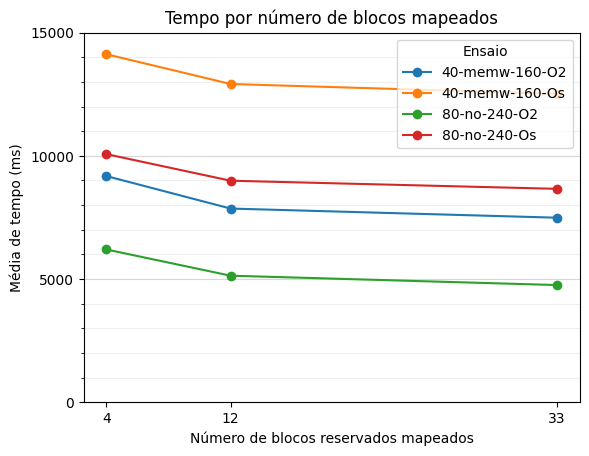

In [47]:
tipo = (4,12,33)
dict_class = _dict_plot

fig,ax = plt.subplots()
ax.plot(tipo,dict_class[list(dict_class.keys())[0]], '-o', label=list(dict_class.keys())[0])
ax.plot(tipo,dict_class[list(dict_class.keys())[1]], '-o', label=list(dict_class.keys())[1])
ax.plot(tipo,dict_class[list(dict_class.keys())[2]], '-o', label=list(dict_class.keys())[2])
ax.plot(tipo,dict_class[list(dict_class.keys())[3]], '-o', label=list(dict_class.keys())[3])
ax.legend(loc='upper right', title='Ensaio')
ax.set_ylabel('Média de tempo (ms)')
ax.set_xlabel('Número de blocos reservados mapeados')
ax.set_title('Tempo por número de blocos mapeados')
major_ticks = np.arange(0, 15001, 5000)
minor_ticks = np.arange(0, 15001, 1000)
ax.set_xticks(tipo)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='minor',alpha=0.2,axis='y')
ax.grid(which='major',alpha=0.5,axis='y')
#plt.savefig("../Imagens autorais PD/HIMEMTempoPorBlocosMapeados--FIX.png", dpi=300)

In [44]:


_dict_plot

{'40-memw-160-O2': (9180.0, 7860.0, 7488.5),
 '40-memw-160-Os': (14125.0, 12915.0, 12515.0),
 '80-no-240-O2': (6200.0, 5135.0, 4755.0),
 '80-no-240-Os': (10070.0, 8990.0, 8660.0)}

In [ ]:
YYY

In [ ]:
XXX

In [ ]:
dic_regress["40-memw-160-O2"]